# Library and Model

In [123]:
!pip install pytube@git+https://github.com/priyankaj1311/pytube.git@master_copy

  Cloning https://github.com/priyankaj1311/pytube.git (to revision master_copy) to /tmp/pip-install-8w5b2uo7/pytube_aa36202fd5d8495ba973d50528a8a175
  Running command git clone --filter=blob:none --quiet https://github.com/priyankaj1311/pytube.git /tmp/pip-install-8w5b2uo7/pytube_aa36202fd5d8495ba973d50528a8a175
  Running command git checkout -b master_copy --track origin/master_copy
  Switched to a new branch 'master_copy'
  Branch 'master_copy' set up to track remote branch 'master_copy' from 'origin'.
  Resolved https://github.com/priyankaj1311/pytube.git to commit 68468bd1c0a2d3cd4166d928f4f7f44913c1f77f
  Preparing metadata (setup.py) ... done


In [124]:
import os
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from pytube import YouTube

In [125]:
mlDataPath = "/content/drive/Shareddrives/Capstone C241-PS416/ML/Data"

In [126]:
# Define indices of keypoints
keypoints_indices = {
    "Nose": 0,
    "Right Eye": 1,
    "Left Eye": 2,
    "Right Ear": 3,
    "Left Ear": 4,
    "Right Shoulder": 5,
    "Left Shoulder": 6,
    "Right Elbow": 7,
    "Left Elbow": 8,
    "Right Wrist": 9,
    "Left Wrist": 10,
    "Right Hip": 11,
    "Left Hip": 12,
    "Right Knee": 13,
    "Left Knee": 14,
    "Right Ankle": 15,
    "Left Ankle": 16
}

In [127]:
# Load MoveNet from TensorFlow Hub
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")

# Functions

## Function to download YouTube video

In [128]:
filename = "SupineFlexion.mp4"

In [137]:
def download_youtube_video(url, output_path, filename='filename'):
    # Ensure the output directory exists
    os.makedirs(output_path, exist_ok=True)

    yt = YouTube(url)
    stream = yt.streams.get_highest_resolution()
    file_path = os.path.join(output_path, f"{filename}.mp4")

    if not os.path.exists(file_path):
        stream.download(output_path=output_path, filename=filename)
    else:
        print(f"File '{filename}.mp4' already exists in '{output_path}', skipping download.")
        print(f"Existing file path: {file_path}")

## Function to detect keypoints

In [130]:
def detect_keypoints(image):
    # MoveNet expects a tensor of shape (1, 256, 256, 3)
    input_image = tf.image.resize_with_pad(image, 256, 256)
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Perform keypoint detection
    model = movenet.signatures['serving_default']
    outputs = model(input_image)['output_0']
    keypoints = outputs.numpy()[0]

    return keypoints

## Function to extract frames from video and keypoints in the video

In [144]:
def extract_frames_and_keypoints(video_path, start_frame, end_frame, frame_interval, output_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return []

    frame_count = 0
    keypoints_list = []

    frames_folder = os.path.join(output_path, 'SupineFlexion', 'frames')
    os.makedirs(frames_folder, exist_ok=True)

    print("Starting frame extraction process...")  # Add this print statement

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count < start_frame:
            frame_count += 1
            continue
        elif frame_count > end_frame:
            break

        # Process every `frame_interval` frame
        if frame_count % frame_interval == 0:
            print(f"Processing frame {frame_count}")
            # Convert the BGR image to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Detect keypoints using MoveNet
            keypoints = detect_keypoints(frame_rgb)

            # Debug: Print the shape of the keypoints array
            print("Shape of keypoints array:", keypoints.shape)

            # Assume `keypoints` is a NumPy array containing the coordinates of keypoints
            selected_keypoints = {}
            for i, name in enumerate(keypoints_indices.keys()):  # Assuming keypoints_indices is a dictionary
                selected_keypoints[f"{name}_x"] = keypoints[0, i, 0]
                selected_keypoints[f"{name}_y"] = keypoints[0, i, 1]

            keypoints_list.append((frame_count, selected_keypoints))

            # Save the frame
            frame_filename = os.path.join(frames_folder, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
            print(f"Saved frame {frame_count}")

        frame_count += 1

    cap.release()
    print("Frame extraction process completed.")
    return keypoints_list

## Function to save keypoints to Excel

In [163]:
def save_keypoints_to_excel(keypoints_list, output_path, filename='keypointSupineFlexion.xlsx'):
    # Convert keypoints_list to DataFrame
    df = pd.DataFrame(keypoints_list, columns=['Frame', 'Keypoints'])

    # Expand Keypoints dictionary into separate columns
    df = pd.concat([df.drop(['Keypoints'], axis=1), df['Keypoints'].apply(pd.Series)], axis=1)

    # Replace 'x' with '_x' and 'y' with '_y' in column names
    df.columns = df.columns.str.replace(' ', '_')

    # Save DataFrame to Excel
    excel_path = os.path.join(output_path, filename)
    df.to_excel(excel_path, index=False)

    return excel_path

# Run (Download, Extract Frames and Keypoints, and Save to Excel)

In [115]:
#Input URL
youtube_url = 'https://www.youtube.com/watch?v=6iEEWUjOkC0'
output_path = mlDataPath  # Current directory

In [135]:
# Download the YouTube video and save it as SupineFlexion.mp4
video_path = download_youtube_video(youtube_url, mlDataPath, filename='SupineFlexion')

File 'SupineFlexion.mp4' already exists in '/content/drive/Shareddrives/Capstone C241-PS416/ML/Data', skipping download.


In [117]:
start_frame = 420  # Start from frame 420
end_frame = 1170  # End at frame 1170
frame_interval = 2  # Extract every 2nd frame
output_path = mlDataPath

In [145]:
keypoints_list = extract_frames_and_keypoints(video_path, start_frame, end_frame, frame_interval, output_path)

Starting frame extraction process...
Processing frame 420
Shape of keypoints array: (1, 17, 3)
Saved frame 420
Processing frame 422
Shape of keypoints array: (1, 17, 3)
Saved frame 422
Processing frame 424
Shape of keypoints array: (1, 17, 3)
Saved frame 424
Processing frame 426
Shape of keypoints array: (1, 17, 3)
Saved frame 426
Processing frame 428
Shape of keypoints array: (1, 17, 3)
Saved frame 428
Processing frame 430
Shape of keypoints array: (1, 17, 3)
Saved frame 430
Processing frame 432
Shape of keypoints array: (1, 17, 3)
Saved frame 432
Processing frame 434
Shape of keypoints array: (1, 17, 3)
Saved frame 434
Processing frame 436
Shape of keypoints array: (1, 17, 3)
Saved frame 436
Processing frame 438
Shape of keypoints array: (1, 17, 3)
Saved frame 438
Processing frame 440
Shape of keypoints array: (1, 17, 3)
Saved frame 440
Processing frame 442
Shape of keypoints array: (1, 17, 3)
Saved frame 442
Processing frame 444
Shape of keypoints array: (1, 17, 3)
Saved frame 444
P

In [164]:
# Save keypoints to Excel
excel_path = save_keypoints_to_excel(keypoints_list, mlDataPath, filename='keypointSupineFlexion.xlsx')

In [165]:
print(f"Video saved to: {video_path}")
print(f"Frames saved to: {os.path.join(mlDataPath, 'SupineFlexion', 'frames')}")
print(f"Keypoints saved to: {excel_path}")

Video saved to: /content/drive/Shareddrives/Capstone C241-PS416/ML/Data/SupineFlexion.mp4
Frames saved to: /content/drive/Shareddrives/Capstone C241-PS416/ML/Data/SupineFlexion/frames
Keypoints saved to: /content/drive/Shareddrives/Capstone C241-PS416/ML/Data/keypointSupineFlexion.xlsx


In [166]:
keypointDf = pd.read_excel("/content/drive/Shareddrives/Capstone C241-PS416/ML/Data/keypointSupineFlexion.xlsx")
keypointDf

,Frame,Nose_x,Nose_y,Right_Eye_x,Right_Eye_y,Left_Eye_x,Left_Eye_y,Right_Ear_x,Right_Ear_y,Left_Ear_x,...,Left_Hip_x,Left_Hip_y,Right_Knee_x,Right_Knee_y,Left_Knee_x,Left_Knee_y,Right_Ankle_x,Right_Ankle_y,Left_Ankle_x,Left_Ankle_y
0,420,0.586302,0.254276,0.595436,0.245979,0.599320,0.242555,0.632570,0.251471,0.636117,...,0.626290,0.515756,0.635333,0.663225,0.640959,0.654990,0.659427,0.813648,0.668805,0.817736
1,422,0.586880,0.252423,0.595498,0.244352,0.600025,0.240728,0.630874,0.253583,0.637697,...,0.625426,0.514316,0.635058,0.662111,0.641497,0.655118,0.659104,0.813477,0.668643,0.817480
2,424,0.585982,0.251452,0.595199,0.243375,0.598156,0.240441,0.629210,0.252296,0.632776,...,0.627824,0.508679,0.635925,0.662474,0.641735,0.654302,0.659364,0.813527,0.668644,0.817372
3,426,0.585296,0.252241,0.594941,0.243977,0.598179,0.240685,0.631882,0.250276,0.633877,...,0.625976,0.514606,0.634130,0.662777,0.640698,0.655756,0.659368,0.813774,0.668932,0.817225
4,428,0.584373,0.252497,0.594544,0.244034,0.597854,0.240529,0.632506,0.250572,0.634689,...,0.626093,0.517899,0.634144,0.662847,0.640795,0.656316,0.659840,0.813832,0.669478,0.817053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,1162,0.587205,0.253291,0.594270,0.245736,0.599448,0.242312,0.629721,0.250716,0.634682,...,0.625479,0.508037,0.635033,0.658779,0.640722,0.656222,0.662577,0.813772,0.668577,0.817741
372,1164,0.588484,0.251724,0.594923,0.244682,0.601011,0.241157,0.629568,0.250611,0.636156,...,0.624758,0.506621,0.634848,0.658818,0.641255,0.655813,0.662282,0.813667,0.668853,0.817719
373,1166,0.588134,0.252269,0.594692,0.245044,0.600740,0.241553,0.629649,0.250807,0.636274,...,0.624781,0.506743,0.634985,0.659298,0.641654,0.656307,0.662255,0.813930,0.669019,0.817560
374,1168,0.588309,0.252201,0.595169,0.244875,0.601038,0.241649,0.629435,0.250386,0.635541,...,0.624601,0.505590,0.634838,0.659711,0.641617,0.656190,0.662337,0.814026,0.668976,0.817699


In [199]:
# Load the image
frame_path = '/content/drive/Shareddrives/Capstone C241-PS416/ML/Data/SupineFlexion/frames/frame_420.jpg'
image = cv2.imread(frame_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

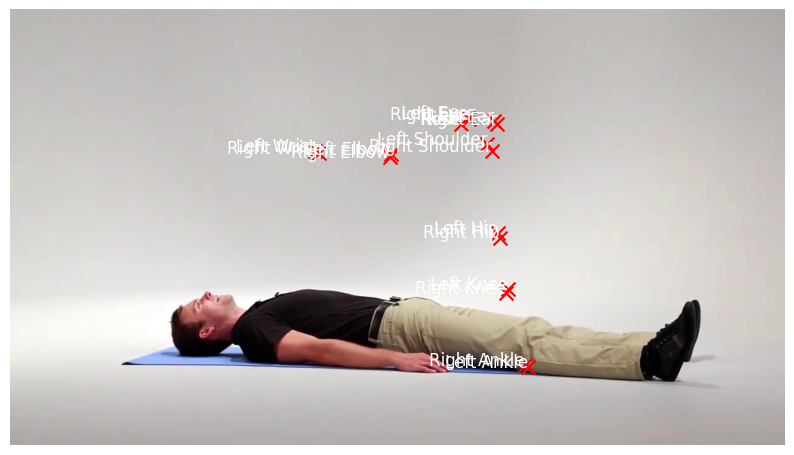

In [210]:
import matplotlib.pyplot as plt
# Keypoints list
keypoints = [
    'Nose', 'Right Eye', 'Left Eye', 'Right Ear', 'Left Ear',
    'Right Shoulder', 'Left Shoulder', 'Right Elbow', 'Left Elbow',
    'Right Wrist', 'Left Wrist', 'Right Hip', 'Left Hip',
    'Right Knee', 'Left Knee', 'Right Ankle', 'Left Ankle'
]

# Extract the keypoints
keypoints_x = [f'{k.replace(" ", "_")}_x' for k in keypoints]
keypoints_y = [f'{k.replace(" ", "_")}_y' for k in keypoints]

# Get the specific frame data
frame_data = keypointDf[keypointDf['Frame'] == 700].iloc[0]

# Get the image dimensions
img_height, img_width, _ = image.shape

# Plot the keypoints on the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)

for k, kx, ky in zip(keypoints, keypoints_x, keypoints_y):
    x = frame_data[kx] * img_width
    y = frame_data[ky] * img_height
    plt.scatter(x, y, s=100, c='red', marker='x')
    plt.text(x, y, k, color='white', fontsize=12, ha='right')

plt.axis('off')
plt.show()

In [212]:
# Load the MoveNet model
interpreter = tf.lite.Interpreter(model_path=movenet)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the input image
def preprocess_image(image_path, input_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (input_size, input_size))
    image_resized = image_resized.astype('float32')
    image_resized = np.expand_dims(image_resized, axis=0)
    image_resized = (image_resized - 127.5) / 127.5
    return image, image_resized

# Preprocess the input image
input_size = input_details[0]['shape'][1]
image_path = "input_image.jpg"  # Replace with your image path
original_image, input_image = preprocess_image(image_path, input_size)

# Run inference
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

# Visualize the keypoints
def visualize_keypoints(image, keypoints):
    height, width, _ = image.shape
    keypoints = np.squeeze(keypoints)
    for keypoint in keypoints:
        y, x, confidence = keypoint[0], keypoint[1], keypoint[2]
        if confidence > 0.5:
            cx, cy = int(x * width), int(y * height)
            cv2.circle(image, (cx, cy), 3, (0, 255, 0), -1)
    return image

# List of keypoints names
keypoint_names = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle"
]

# Display the image with keypoints
output_image = visualize_keypoints(original_image, keypoints_with_scores)
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

TypeError: CreateWrapperFromFile(): incompatible function arguments. The following argument types are supported:
    1. (arg0: str, arg1: int, arg2: List[str], arg3: bool, arg4: bool) -> tflite::interpreter_wrapper::InterpreterWrapper
    2. (arg0: str, arg1: int, arg2: List[str], arg3: List[Callable[[int], None]], arg4: bool, arg5: bool) -> tflite::interpreter_wrapper::InterpreterWrapper

Invoked with: <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x78b697e49060>, 1, [], [], False, False